<a href="https://colab.research.google.com/github/aymenchibouti/doctorat/blob/main/2026.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:27:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


=== Evaluation Results ===
Accuracy : 0.7944336140030694
Precision: 0.7943683155080213
Recall   : 0.998215035699286
F1 Score : 0.8847012841987716


<Figure size 1200x600 with 0 Axes>

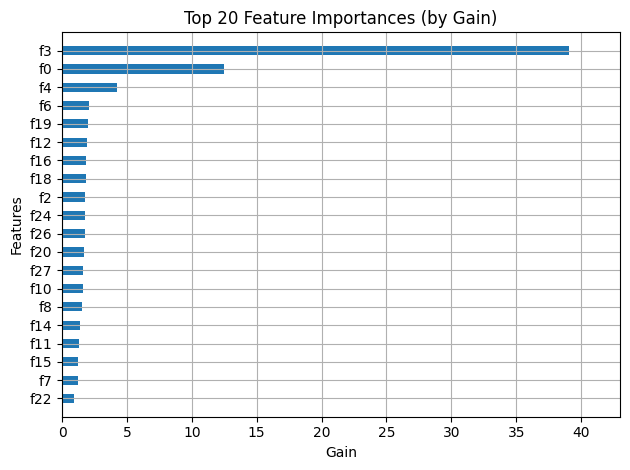

In [4]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier, plot_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# ------------------------------
# Load and preprocess data
# ------------------------------
def load_data():
    # Load data
    enrollment = pd.read_csv("enrollment_train.csv")
    logs = pd.read_csv("log_train spliting.csv")
    truth = pd.read_csv("truth_train.csv", header=None, names=['enrollment_id', 'label'])

    # Prepare timestamps and merge
    logs['time'] = pd.to_datetime(logs['time'])
    logs = logs.merge(enrollment, on='enrollment_id', how='left')
    logs['start_time'] = logs.groupby('enrollment_id')['time'].transform('min')
    logs['day'] = (logs['time'] - logs['start_time']).dt.days
    logs = logs[(logs['day'] >= 0) & (logs['day'] < 30)]

    # Behavioral features
    behaviors = ['access', 'problem', 'discussion', 'navigate', 'video', 'wiki', 'page_close']
    enrollment_ids = enrollment['enrollment_id'].unique()
    eid_to_index = {eid: idx for idx, eid in enumerate(enrollment_ids)}
    behavior_to_index = {b: i for i, b in enumerate(behaviors)}

    # Initialize tensor
    feature_tensor = np.zeros((len(enrollment_ids), 30, len(behaviors)), dtype=np.float32)

    # Populate tensor
    for _, row in logs.iterrows():
        if row['event'] in behavior_to_index:
            i = eid_to_index[row['enrollment_id']]
            d = row['day']
            j = behavior_to_index[row['event']]
            feature_tensor[i, d, j] += 1

    # Labels
    labels = np.array([
        truth[truth['enrollment_id'] == eid]['label'].values[0]
        for eid in enrollment_ids
    ])

    return feature_tensor, labels, behaviors

# ------------------------------
# Flatten time series features into statistical summaries
# ------------------------------
def flatten_features(X, behaviors):
    stats = []
    feature_names = []

    for i, behavior in enumerate(behaviors):
        data = X[:, :, i]
        stats.append(data.sum(axis=1))            # Total
        stats.append(data.mean(axis=1))           # Mean
        stats.append(data.std(axis=1))            # Std Dev
        stats.append((data > 0).sum(axis=1))      # Active days
        feature_names.extend([
            f"{behavior}_sum", f"{behavior}_mean",
            f"{behavior}_std", f"{behavior}_active_days"
        ])

    return np.stack(stats, axis=1), feature_names

# ------------------------------
# Train XGBoost and evaluate
# ------------------------------
def train_xgboost():
    # Step 1: Load and preprocess
    X_ts, y, behaviors = load_data()
    X, feature_names = flatten_features(X_ts, behaviors)

    # Step 2: Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Step 3: Train model
    model = XGBClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        use_label_encoder=False,
        eval_metric='logloss'
    )
    model.fit(X_train, y_train)

    # Step 4: Predict and evaluate
    y_pred = model.predict(X_test)
    print("=== Evaluation Results ===")
    print("Accuracy :", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall   :", recall_score(y_test, y_pred))
    print("F1 Score :", f1_score(y_test, y_pred))

    # Step 5: Plot feature importances
    plt.figure(figsize=(12, 6))
    plot_importance(model, importance_type='gain', max_num_features=20,
                    show_values=False, height=0.5, xlabel="Gain")
    plt.title("Top 20 Feature Importances (by Gain)")
    plt.tight_layout()
    plt.show()

# ------------------------------
# Main
# ------------------------------
if __name__ == "__main__":
    train_xgboost()


SyntaxError: invalid syntax (ipython-input-6-2309004260.py, line 1)

In [7]:
flatten_features

<function __main__.flatten_features(X, behaviors)>